# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\sujpanda\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\sujpanda\\Desktop\\applied\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:27<00:00, 1657.12it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 76%|███████▌  | 34840/46071 [00:15<00:04, 2483.17it/s]C:\Users\sujpanda\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 46071/46071 [00:20<00:00, 2221.09it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## Some utility functions

In [26]:
def check_trade_off(X_train,X_test,y_train,y_test):
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    
    C_range1 = ['0.00001','0.001','1','100','10000',]
    C_range = [0.00001,0.001,1,100,10000]
    dummy_range = [1,2,3,4,5]

    auc_scores =[]
    auc_train_scores = []

    i = 0
    for i in C_range:
        clf = SVC(C=i)

        # fitting the model on crossvalidation train
        clf.fit(X_train, y_train)
        
        model = CalibratedClassifierCV(clf, cv='prefit')
        model.fit(X_train, y_train)

        
        #evaluate AUC score.
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        # calculate AUC
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.3f' % auc)
        auc_scores.append(auc)
   
    print('#######################################################')
    print('AUC from train data ###################################')
    i = 0
    for i in C_range:
        clf = SVC(C=i)

        # fitting the model on crossvalidation train
        clf.fit(X_train, y_train)
        
        model = CalibratedClassifierCV(clf, cv='prefit')
        model.fit(X_train, y_train)
        
        #evaluate AUC score.
        probs = model.predict_proba(X_train)
        probs = probs[:, 1]
        # calculate AUC
        auc = roc_auc_score(y_train, probs)
        print('AUC: %.3f' % auc)
        auc_train_scores.append(auc) 

    plt.plot(dummy_range, auc_scores,'r')
    plt.plot(dummy_range, auc_train_scores,'b')
    plt.xticks(dummy_range, C_range1, rotation='vertical')
    for xy in zip(dummy_range, auc_scores):
        plt.annotate('(%f, %f)' % xy, xy=xy, textcoords='data')
    for xy in zip(dummy_range, auc_train_scores):
        plt.annotate('(%f, %f)' % xy, xy=xy, textcoords='data')


    plt.xlabel('alpha-Values')
    plt.ylabel('auc_scores')
    plt.show()


In [27]:
def check_trade_off_sgd(X_train,X_test,y_train,y_test):
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    
    C_range1 = ['0.00001','0.001','1','100','10000',]
    C_range = [0.00001,0.001,1,100,10000]
    dummy_range = [1,2,3,4,5]

    auc_scores =[]
    auc_train_scores = []

    i = 0
    for i in C_range:
        clf = SGDClassifier(loss='hinge', alpha=i)


        # fitting the model on crossvalidation train
        clf.fit(X_train, y_train)
        
        model = CalibratedClassifierCV(clf, cv='prefit')
        model.fit(X_train, y_train)

        
        #evaluate AUC score.
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        # calculate AUC
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.3f' % auc)
        auc_scores.append(auc)
   
    print('#######################################################')
    print('AUC from train data ###################################')
    i = 0
    for i in C_range:
        clf = SGDClassifier(loss='hinge', alpha=i)

        # fitting the model on crossvalidation train
        clf.fit(X_train, y_train)
        
        model = CalibratedClassifierCV(clf, cv='prefit')
        model.fit(X_train, y_train)
        
        #evaluate AUC score.
        probs = model.predict_proba(X_train)
        probs = probs[:, 1]
        # calculate AUC
        auc = roc_auc_score(y_train, probs)
        print('AUC: %.3f' % auc)
        auc_train_scores.append(auc) 

    plt.plot(dummy_range, auc_scores,'r')
    plt.plot(dummy_range, auc_train_scores,'b')
    plt.xticks(dummy_range, C_range1, rotation='vertical')
    for xy in zip(dummy_range, auc_scores):
        plt.annotate('(%f, %f)' % xy, xy=xy, textcoords='data')
    for xy in zip(dummy_range, auc_train_scores):
        plt.annotate('(%f, %f)' % xy, xy=xy, textcoords='data')


    plt.xlabel('C-Values')
    plt.ylabel('auc_scores')
    plt.show()


In [28]:
def sgd_results(ialpha,input_penalty,X_train,X_test,y_train,y_test):
    # roc curve and auc
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot
    # ============================== Logistic regression===============================================
    clf = SGDClassifier(alpha=ialpha,loss='hinge', penalty=input_penalty)

    # fitting the model
    clf.fit(X_train, y_train)

    # predict the response
    pred = clf.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the SGD classifier for alpha = %f is %f%%' % (ialpha, acc))

    model = CalibratedClassifierCV(clf, cv='prefit')
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.show()
    from sklearn.metrics import confusion_matrix
    con_mat = confusion_matrix(y_test, pred, [0, 1])
    return con_mat,clf

In [29]:
def svc_results(c,X_train,X_test,y_train,y_test):
    # roc curve and auc
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot
    # ============================== Logistic regression===============================================
    clf = SVC(C=c)

    # fitting the model
    clf.fit(X_train, y_train)

    # predict the response
    pred = clf.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the SVC classifier for alpha = %f is %f%%' % (c, acc))

    model = CalibratedClassifierCV(clf, cv='prefit')
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.show()
    from sklearn.metrics import confusion_matrix
    con_mat = confusion_matrix(y_test, pred, [0, 1])
    return con_mat,clf

In [30]:
def showHeatMap(con_mat):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(con_mat, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [246]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

In [247]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000000.0,
       n_iter=None, n_jobs=1, penalty='l1', power_t=0.5,
       random_state=123456, shuffle=True, tol=1e-06, verbose=0,
       warm_start=False)
0.896747045245148
AUC: 0.907
AUC: 0.925
AUC: 0.511
AUC: 0.581
AUC: 0.581
#######################################################
AUC from train data ###################################
AUC: 0.974
AUC: 0.975
AUC: 0.517
AUC: 0.573
AUC: 0.573


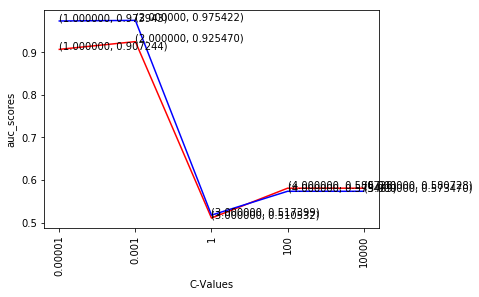

In [248]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_1)
final_test_count = count_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr)
final_test_count_cv = count_vect.transform(X_cv)

sgd = SGDClassifier(loss='hinge', penalty='l1', max_iter=1E6, tol=1E-6, shuffle=True, random_state=123456)
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

sgd_gs = GridSearchCV(sgd, tuned_parameters, scoring='roc_auc', n_jobs=4, cv=4)
sgd_gs.fit(final_counts_tr_cv, y_tr)

print(sgd_gs.best_estimator_)
print(sgd_gs.score(final_test_count_cv, y_cv))

check_trade_off_sgd(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)


The accuracy of the SGD classifier for alpha = 0.000100 is 90.175083%
AUC: 0.909


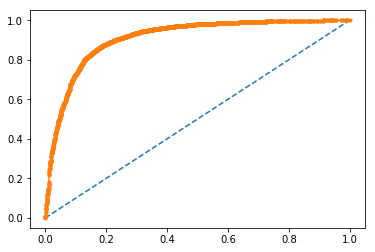

In [249]:
con_mat,clf = sgd_results(0.0001,'l1',final_counts,final_test_count,y_1,y_test)

Observation: With alpha = 0.0001 the model predicted with accuracy 90% with auc value 0.909. 

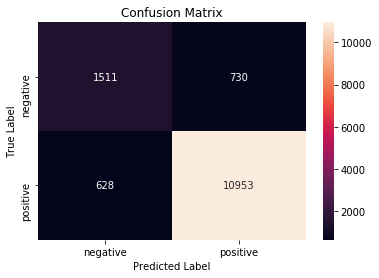

In [250]:
showHeatMap(con_mat)

Observation: My model has predicted 628 + 730 points wrongly


The accuracy of the SGD classifier for alpha = 0.000100 is 89.979742%
AUC: 0.922


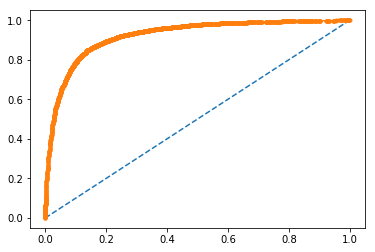

In [251]:
con_mat,clf = sgd_results(0.0001,'l2',final_counts,final_test_count,y_1,y_test)

Observation: With l2 regularier there is an improvement in AUC score: 0.922 but accuracy reduced to 89. So we can take l2 regularizer for our modeling penalty

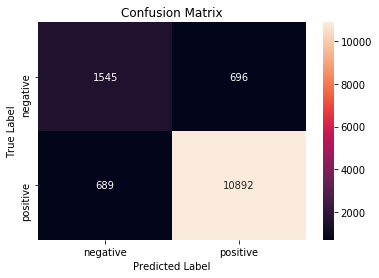

In [252]:
showHeatMap(con_mat)

Observation: My model has predicted 689 + 696 points wrongly

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [256]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.942661738682314
AUC: 0.948
AUC: 0.953
AUC: 0.608
AUC: 0.608
AUC: 0.608
#######################################################
AUC from train data ###################################
AUC: 0.999
AUC: 0.973
AUC: 0.603
AUC: 0.603
AUC: 0.603


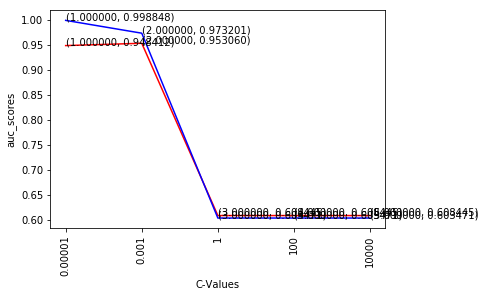

In [257]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_1)
final_tf_idf = tf_idf_vect.transform(X_1)
final_test_count = tf_idf_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = tf_idf_vect.transform(X_tr)
final_test_count_cv = tf_idf_vect.transform(X_cv)

sgd = SGDClassifier(loss='hinge', penalty='l1')
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(sgd, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(final_counts_tr_cv, y_tr)

print(model.best_estimator_)
print(model.score(final_test_count_cv, y_cv))

check_trade_off_sgd(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)


The accuracy of the SGD classifier for alpha = 0.000100 is 90.594704%
AUC: 0.938


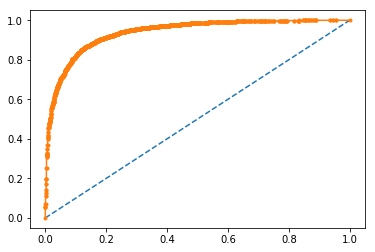

In [258]:
con_mat,clf = sgd_results(0.0001,'l1',final_tf_idf,final_test_count,y_1,y_test)

Observation: Model accuracy is 90% with AUC 0.938 when alpha is 0.0001 is very good.

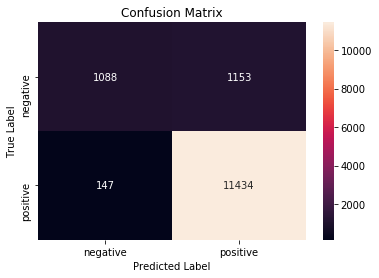

In [259]:
showHeatMap(con_mat)

Observation: My model predicted 147 + 1153 points wrongly


The accuracy of the SGD classifier for alpha = 0.000100 is 91.991029%
AUC: 0.957


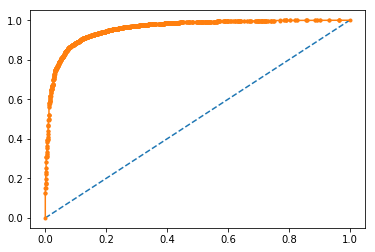

In [260]:
con_mat,clf = sgd_results(0.0001,'l2',final_tf_idf,final_test_count,y_1,y_test)

Observation: There is an improvment in accuracy and AUC score with l2 regularizer

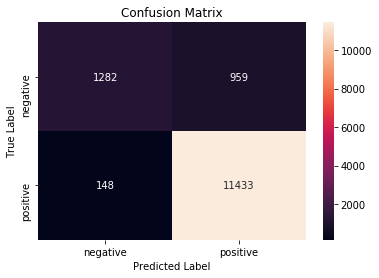

In [261]:
showHeatMap(con_mat)

Observation: My model pedicted 148 + 959 points wrongly

In [262]:
feature_names = np.array(tf_idf_vect.get_feature_names())
sorted_coef_index = clf.coef_[0].argsort()

In [263]:
print('Top 10 positive features: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Top 10 positive features: 
['great' 'best' 'not disappointed' 'good' 'delicious' 'love' 'loves'
 'perfect' 'nice' 'amazing']



In [264]:
print('Top 10 negative features: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))

Top 10 negative features: 
['disappointed' 'worst' 'disappointing' 'awful' 'terrible' 'not'
 'not worth' 'horrible' 'return' 'not buy']



### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [265]:
X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

In [266]:
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(sent_vectors[0])



i=0
list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())
    
test_sent_vectors = [];

for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(test_sent_vectors[0])


100%|██████████| 32249/32249 [01:37<00:00, 331.40it/s]


[-0.70691314  0.05065851  0.38964034  0.41985835 -0.15152602 -0.35196786
 -0.25724678  0.76638044 -0.39063415  0.23186132  0.01135624  0.72326949
  0.39849825  0.22387371  0.44969949 -0.22087011 -0.46912268 -0.23675963
 -0.70967436  0.25106571 -0.11730615 -0.77854294  0.01344337  0.18702311
 -0.22319833 -0.32387671  0.09090055  0.61399192  0.11950142 -0.28587672
 -0.34326136  0.1365347   0.43636839 -0.04377889  0.65825292  0.7888547
  0.73269657 -1.08797595  0.14471799  0.07504993  0.56114913  0.75004656
  0.05591206  1.47118579  0.24307241  0.02181004 -0.1158606  -0.53840384
  0.17297038 -0.01418458]


100%|██████████| 13822/13822 [00:40<00:00, 337.49it/s]


[-0.08702452  0.87213708 -0.14136428 -0.53127171  0.27896474 -0.46044726
  0.17758902  0.23505041  0.20815672 -0.25931918  0.38914516  0.76943186
  0.31039679 -0.02028641  0.36017377  0.06350766 -0.85478444  0.46329409
 -0.06438248  0.17123638  0.00314233 -0.85083322  0.40200057  0.90913207
 -0.05381919 -0.02819401  0.35263796  0.39815592  0.14521132 -0.13482394
  0.28653227  0.84173924 -0.24695739  0.25987838  0.51266812  0.19894371
 -0.13075611  0.01975332  0.05176046  0.30230368 -0.04269703  1.40780166
 -0.44513858  0.26430924 -0.06118238  0.1416377  -0.17230816 -1.21707915
  0.19628136  0.49163068]


100%|██████████| 22574/22574 [01:04<00:00, 350.10it/s]


[ 0.08510495  0.26092592 -0.79238879 -1.3508834   0.1863163   0.11327625
 -0.53192805 -0.69178598 -0.49748244  0.04794091  0.24380035  0.4417329
  1.32874974 -0.32551921  0.41531095  1.03252378  0.13753669 -0.7313178
  0.18786763  0.21914234 -0.47548723 -0.63648485  0.80846777  1.36391416
  0.36101585 -0.2344835   0.30594579  0.58087065 -1.37438641 -0.61767826
  0.05150555  0.92075367 -1.19195867  0.28509153  0.54597462 -0.3566633
 -0.58560209 -0.17822589 -0.1889485   0.56225488  0.4105128  -0.62780031
 -0.40520856  1.39424051  0.89706699  0.42032172 -0.78082825 -0.82834497
 -0.70316356 -0.47892136]


100%|██████████| 9675/9675 [00:27<00:00, 353.71it/s]


[ 0.23674532  0.48092168 -0.48189216 -1.19358868 -0.30842771 -0.07806226
 -0.10428937 -0.18510295 -0.00796553 -0.43365363  0.60801747  0.57487001
  0.12955645  0.24113405  0.0834538  -0.33371197 -0.41175283 -0.21911259
  0.06936753  0.14725839 -0.57582733 -0.4676146   0.47448143  0.67059709
  0.15942912 -0.18546413 -0.08690518 -0.05383114 -0.57850386  0.08525441
  0.21540359  0.6891708  -0.79119456  0.54539031  0.28150502 -0.2014107
  0.1465843   0.39709588  0.58634039  0.06259895 -0.2334361  -0.02668138
 -0.07403829  0.26700662  0.00827627 -0.24273524  0.08547828 -1.23042495
 -0.26745986  0.25093822]
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8877449843715736
AUC: 0.867
AUC: 0.894
AUC: 0.893
AUC: 0.638
AUC:

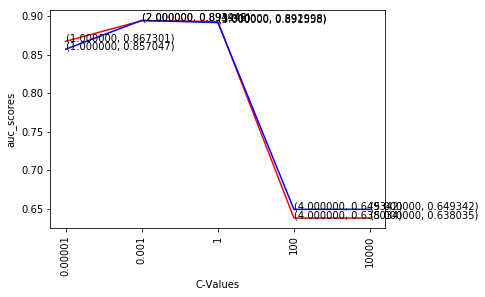

In [267]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_1, test_size=0.3)

i=0
list_of_cv_sentance=[]
for sentance in X_tr:
    list_of_cv_sentance.append(sentance.split())
    
cv_train_sent_vectors = [];

for sent in tqdm(list_of_cv_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_train_sent_vectors.append(sent_vec)
print(cv_train_sent_vectors[0])

i=0
list_of_cv_test_sentance=[]
for sentance in X_cv:
    list_of_cv_test_sentance.append(sentance.split())
    
cv_test_sent_vectors = [];

for sent in tqdm(list_of_cv_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_test_sent_vectors.append(sent_vec)
print(cv_test_sent_vectors[0])

sgd = SGDClassifier(loss='hinge', penalty='l1')
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(sgd, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(cv_train_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(cv_test_sent_vectors, y_cv))

check_trade_off_sgd(cv_train_sent_vectors,cv_test_sent_vectors,y_tr,y_cv)


The accuracy of the SGD classifier for alpha = 0.000100 is 87.599479%
AUC: 0.888


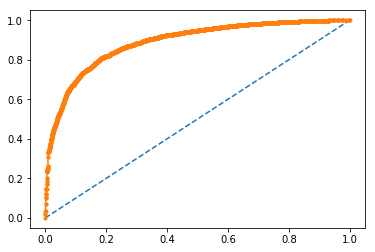

In [268]:
con_mat,clf = sgd_results(0.0001,'l1',sent_vectors,test_sent_vectors,y_1,y_test)

Observation: My model has predicted with 87 accuracy with AUC: 0.888

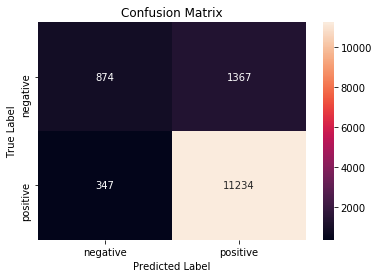

In [269]:
showHeatMap(con_mat)

Observation: My model predicted 347 + 1367 points wrongly


The accuracy of the SGD classifier for alpha = 0.000100 is 87.425843%
AUC: 0.880


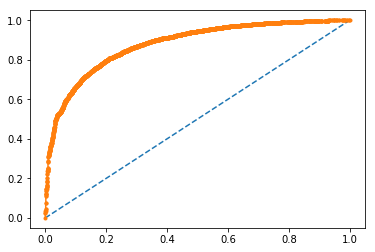

In [270]:
con_mat,clf = sgd_results(0.0001,'l2',sent_vectors,test_sent_vectors,y_1,y_test)

Observation: Not much difference between l1 and l2 regularizer output

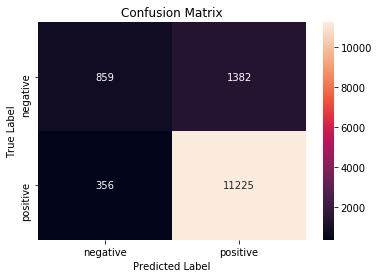

In [271]:
showHeatMap(con_mat)

Observation: My model predicted 356 + 1382 points wrongly

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [272]:
X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

In [273]:
model = TfidfVectorizer()
X_train_transformed = model.fit_transform(X_train)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [274]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [275]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [276]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 32249/32249 [18:54<00:00, 28.41it/s] 


In [277]:
i=0
list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())

In [278]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 13822/13822 [08:23<00:00, 27.45it/s]


100%|██████████| 9675/9675 [06:20<00:00, 25.42it/s]


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8630297111241529
AUC: 0.828
AUC: 0.868
AUC: 0.833
AUC: 0.634
AUC: 0.634
#######################################################
AUC from train data ###################################
AUC: 0.842
AUC: 0.871
AUC: 0.869
AUC: 0.629
AUC: 0.629


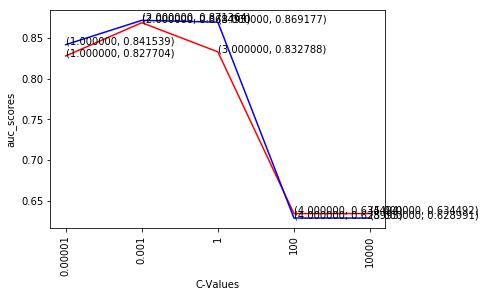

In [279]:
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_1, test_size=0.3)

i=0
list_of_cv_sentance=[]
for sentance in X_tr:
    list_of_cv_sentance.append(sentance.split())
    
    
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_sent_vectors.append(sent_vec)
    row += 1
    
i=0
list_of_cv_test_sentance=[]
for sentance in X_cv:
    list_of_cv_test_sentance.append(sentance.split())
    
    
tfidf_cv_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_test_sent_vectors.append(sent_vec)
    row += 1
    
    
sgd = SGDClassifier(loss='hinge', penalty='l1')
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    
#Using GridSearchCV
model = GridSearchCV(sgd, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_cv_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(tfidf_cv_test_sent_vectors, y_cv))

check_trade_off_sgd(tfidf_cv_sent_vectors,tfidf_cv_test_sent_vectors,y_tr,y_cv)



The accuracy of the SGD classifier for alpha = 0.000100 is 83.330922%
AUC: 0.840


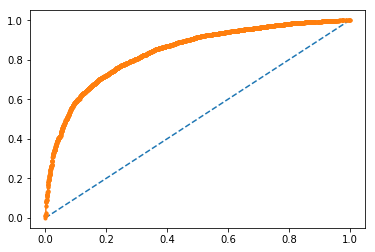

In [280]:
con_mat,clf = sgd_results(0.0001,'l1',tfidf_sent_vectors,tfidf_test_sent_vectors,y_1,y_test)

Observation: Model predicted with accuracy 83 % and 0.840 auc score.

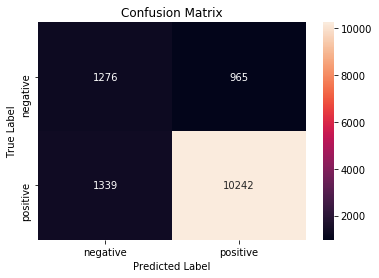

In [281]:
showHeatMap(con_mat)

Observation: My model predicted 1339 + 965 points wrongly


The accuracy of the SGD classifier for alpha = 0.000100 is 86.166980%
AUC: 0.852


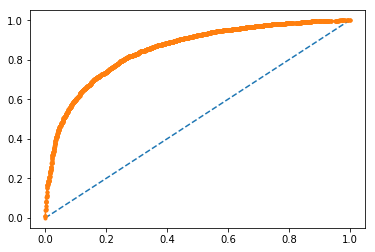

In [282]:
con_mat,clf = sgd_results(0.0001,'l2',tfidf_sent_vectors,tfidf_test_sent_vectors,y_1,y_test)

Observation: There is not much difference between l1 and l2 regularizer

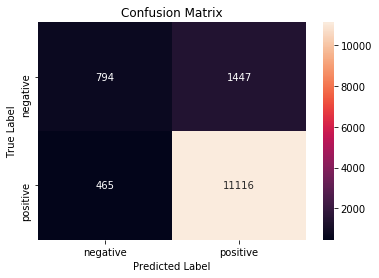

In [283]:
showHeatMap(con_mat)

Observation: My model predicted 456 + 1447 points wrongly

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [284]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9029186572977717
AUC: 0.676
AUC: 0.885
AUC: 0.893
AUC: 0.903
AUC: 0.847
#######################################################
AUC from train data ###################################
AUC: 0.680
AUC: 0.901
AUC: 0.913
AUC: 0.969
AUC: 1.000


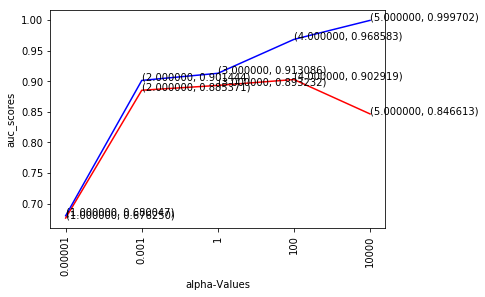

In [285]:
count_vect = CountVectorizer(min_df=10, max_features=500)
final_counts = count_vect.fit_transform(X_1)
final_test_count = count_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr)
final_test_count_cv = count_vect.transform(X_cv)


tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(final_counts_tr_cv, y_tr)

print(model.best_estimator_)
print(model.score(final_test_count_cv, y_cv))
check_trade_off(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)


The accuracy of the SGD classifier for alpha = 100.000000 is 88.793228%
AUC: 0.906


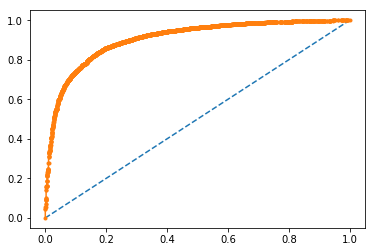

In [286]:
con_mat,clf = svc_results(100,final_counts,final_test_count,y_1,y_test)

observation: The model predicted 88% accuracy with AUC: 906 when c = 100

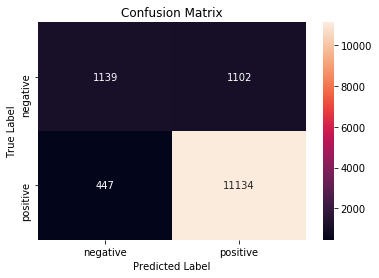

In [287]:
showHeatMap(con_mat)

Observation: This model predicted 447 + 1102 points wrongly

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [288]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9061422815171389
AUC: 0.843
AUC: 0.843
AUC: 0.900
AUC: 0.904
AUC: 0.906
#######################################################
AUC from train data ###################################
AUC: 0.851
AUC: 0.851
AUC: 0.911
AUC: 0.918
AUC: 0.929


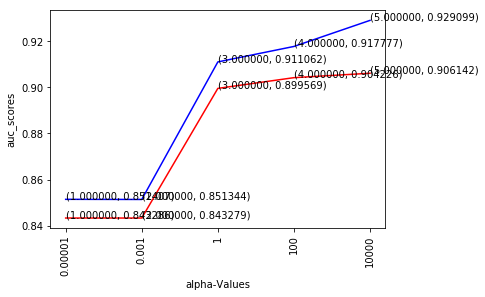

In [289]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(X_1)
final_tf_idf = tf_idf_vect.transform(X_1)
final_test_count = tf_idf_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = tf_idf_vect.transform(X_tr)
final_test_count_cv = tf_idf_vect.transform(X_cv)

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(final_counts_tr_cv, y_tr)

print(model.best_estimator_)
print(model.score(final_test_count_cv, y_cv))

check_trade_off(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)


The accuracy of the SVC classifier for alpha = 10000.000000 is 88.894516%
AUC: 0.907


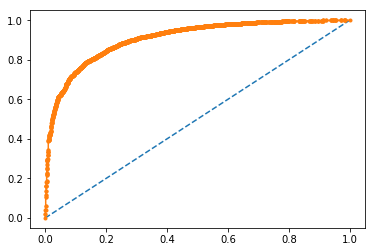

In [291]:
con_mat,clf = svc_results(10000,final_tf_idf,final_test_count,y_1,y_test)

Observation: Model predicted 88% accuracy with AUC score: 0.907

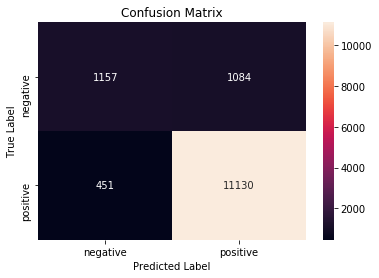

In [293]:
showHeatMap(con_mat)

Observation: My model predicted 451 + 1084 points wrongly

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [294]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

In [295]:
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(sent_vectors[0])



i=0
list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())
    
test_sent_vectors = [];

for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(test_sent_vectors[0])


100%|██████████| 32249/32249 [01:32<00:00, 348.24it/s]


[-0.3229212   0.0909635   0.14200178  0.43835705  0.18845611 -0.43789002
  0.05517153  0.70787672 -0.71328895  0.77850036  0.26874793  0.95412588
  0.52620311  0.11158776  0.10857141  0.09850775 -0.52109222 -0.17406479
 -0.85310262  0.08417704 -0.34046573 -0.68380223  0.01221205  0.05715774
 -0.26670442 -0.43873761 -0.44164987  0.56933045 -0.13125047 -0.35325936
 -0.49677751  0.12477424  0.3830783   0.04410631  0.38815009  0.62609032
  0.45125122 -0.9022373   0.13413235  0.08155093  0.4543668   0.93590224
  0.11707443  1.46638633 -0.04939898  0.35705601  0.15852814 -0.51596832
  0.25066362 -0.20028094]


100%|██████████| 13822/13822 [00:41<00:00, 332.90it/s]


[-0.10094378  1.11984005 -0.04321185 -0.4043802   0.37045777 -0.63383948
  0.09150795  0.10056138  0.37985576 -0.31994779  0.46529526  0.83320616
  0.40134423 -0.02841795  0.2435701   0.06110854 -0.9379301   0.53725673
 -0.12202664  0.35432463  0.04880635 -0.70764226  0.28782641  1.04118215
  0.07696167  0.04706393 -0.05136644  0.38052209  0.03635978  0.04588852
  0.077943    0.89141433 -0.13332699  0.31047307  0.57601362  0.16244922
 -0.20730958 -0.02952294 -0.17687802 -0.08034172  0.16575303  1.23290972
 -0.23976431  0.58490628 -0.08059081  0.6494041   0.17343514 -0.8229991
 -0.26132654  0.60701266]


100%|██████████| 22574/22574 [01:05<00:00, 346.54it/s]


[-0.2905551   0.62139706 -0.03318877 -0.49136731  0.09006259 -0.01776666
 -0.17018281  0.03852796  0.35760078  0.04350535  0.48829077  0.52911945
  0.16666693  0.03080599  0.50328009 -0.29323572 -0.80406415 -0.32414489
 -0.02110795 -0.17709955 -0.57182706 -0.35559807  0.11828896  0.55597643
  0.04393607 -0.31599329 -0.05026706  0.42649929 -0.15260916  0.11197962
  0.26053023  0.20524775 -0.2526622   0.29333542  0.07927508 -0.18340579
  0.00891723 -0.29392766  0.20088845  0.13866965 -0.08526035  0.43451062
 -0.037705    0.57984516 -0.03342701  0.38694469 -0.0286005  -0.62059804
 -0.39589116 -0.13186588]


100%|██████████| 9675/9675 [00:28<00:00, 343.38it/s]


[-0.73731186  0.45247821 -0.20114915 -0.77948135  0.69915743 -0.60044611
 -0.48607216 -0.44931495  0.15578087 -0.24672109  0.19700561  1.08026159
 -0.1196873  -0.95607778 -0.01002884  0.3647039   0.19647758 -0.20182659
 -0.53337809  0.34062649 -1.00834926 -0.34266816  0.41765108  0.17859725
 -0.23061378 -0.64971501  0.1354455   1.22837861 -0.83665973 -0.76216334
 -1.07714029 -0.02715902 -0.48696535  0.53525911  0.90515195  0.12492945
 -0.33667326  0.88673962  0.09865461  0.91019244 -0.04071382 -0.70085437
 -0.0475254  -0.06126182 -0.20639705  0.24520903 -0.72075997 -0.68022136
 -0.33296668 -0.33773697]
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.907804705239104
AUC: 0.864
AUC: 0.894
AUC: 0.904
AUC: 0.908
AUC: 0.878
#######################################################
AUC from train data ################

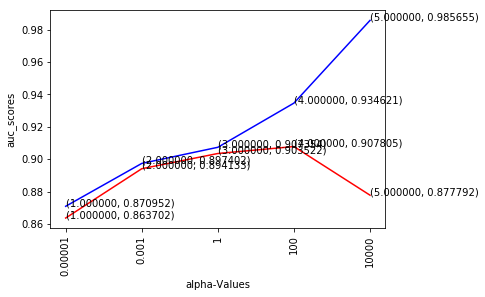

In [296]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_1, test_size=0.3)

i=0
list_of_cv_sentance=[]
for sentance in X_tr:
    list_of_cv_sentance.append(sentance.split())
    
cv_train_sent_vectors = [];

for sent in tqdm(list_of_cv_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_train_sent_vectors.append(sent_vec)
print(cv_train_sent_vectors[0])

i=0
list_of_cv_test_sentance=[]
for sentance in X_cv:
    list_of_cv_test_sentance.append(sentance.split())
    
cv_test_sent_vectors = [];

for sent in tqdm(list_of_cv_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_test_sent_vectors.append(sent_vec)
print(cv_test_sent_vectors[0])

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(cv_train_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(cv_test_sent_vectors, y_cv))

check_trade_off(cv_train_sent_vectors,cv_test_sent_vectors,y_tr,y_cv)


The accuracy of the SVC classifier for alpha = 100.000000 is 88.843872%
AUC: 0.906


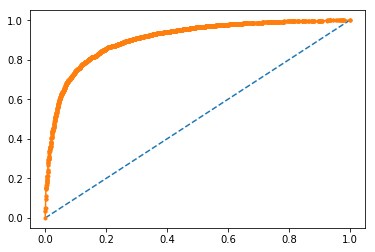

In [297]:
con_mat,clf = svc_results(100,sent_vectors,test_sent_vectors,y_1,y_test)

Observation: Model predicted with accuracy 88 % with AUC: 0.906

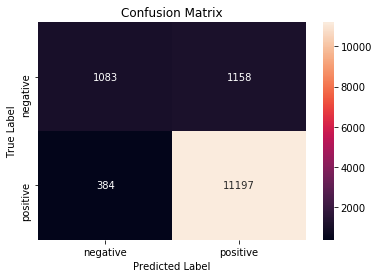

In [298]:
showHeatMap(con_mat)

Observation: My model predicted 384 + 1158 points wrongly

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [299]:
X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

In [300]:
model = TfidfVectorizer()
X_train_transformed = model.fit_transform(X_train)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [301]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [302]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [303]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 32249/32249 [19:22<00:00, 27.74it/s] 


In [304]:
i=0
list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())

In [305]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 13822/13822 [07:58<00:00, 26.55it/s]


100%|██████████| 9675/9675 [06:14<00:00, 17.69it/s]


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8963067589437549
AUC: 0.814
AUC: 0.875
AUC: 0.884
AUC: 0.896
AUC: 0.856
#######################################################
AUC from train data ###################################
AUC: 0.819
AUC: 0.878
AUC: 0.890
AUC: 0.929
AUC: 0.987


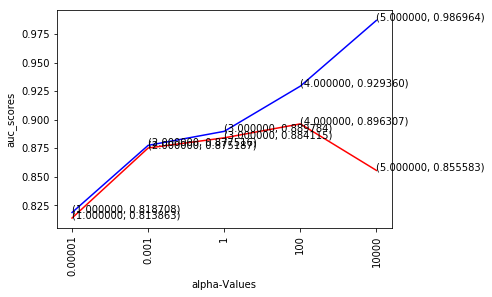

In [306]:
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_1, test_size=0.3)

i=0
list_of_cv_sentance=[]
for sentance in X_tr:
    list_of_cv_sentance.append(sentance.split())
    
    
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_sent_vectors.append(sent_vec)
    row += 1
    
i=0
list_of_cv_test_sentance=[]
for sentance in X_cv:
    list_of_cv_test_sentance.append(sentance.split())
    
    
tfidf_cv_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_test_sent_vectors.append(sent_vec)
    row += 1
    
    
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_cv_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(tfidf_cv_test_sent_vectors, y_cv))

check_trade_off(tfidf_cv_sent_vectors,tfidf_cv_test_sent_vectors,y_tr,y_cv)



The accuracy of the SVC classifier for alpha = 100.000000 is 88.105918%
AUC: 0.892


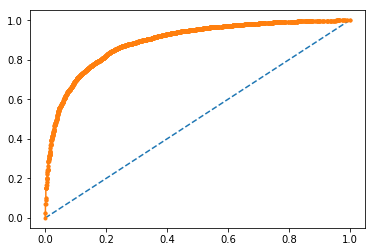

In [307]:
con_mat,clf = svc_results(100,tfidf_sent_vectors,tfidf_test_sent_vectors,y_1,y_test)

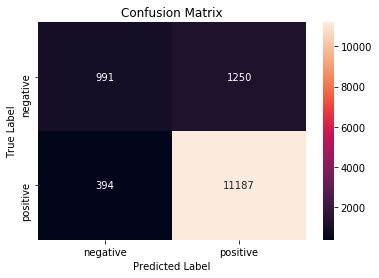

In [308]:
showHeatMap(con_mat)

## Repeat with extra features

In [38]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

C:\Users\sujpanda\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\sujpanda\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [39]:
mylen = np.vectorize(len)
newarr = mylen(preprocessed_summary)

In [40]:
newproce_reviews = np.asarray(preprocessed_reviews)

In [41]:
newproce_summary = np.asanyarray(preprocessed_summary)

In [42]:
df = pd.DataFrame({'desc':newproce_reviews, 'summary':newproce_summary,'len':newarr})

In [43]:
df.head()

,desc,summary,len
0,dogs loves chicken product china wont buying a...,made china,10
1,dogs love saw pet store tag attached regarding...,dog lover delites,17
2,product available victor traps unreal course t...,thirty bucks,12
3,used victor fly bait seasons ca not beat great...,flies begone,12
4,received shipment could hardly wait try produc...,wow make islickers,18


In [44]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(df, final['Score'], test_size=0.3, random_state=0)

In [45]:
import scipy
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_1['desc'])
final_test_count = count_vect.transform(X_test['desc'])

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr['desc'])
final_test_count_cv = count_vect.transform(X_cv['desc'])

from scipy.sparse import csr_matrix, issparse

##################Adding len as feature##########################
#if issparse(final_counts_tr_cv):
    #print('sparse matrix')
len_sparse = scipy.sparse.coo_matrix(X_tr['len'])
len_sparse = len_sparse.transpose()

final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, len_sparse])
print(final_counts_tr_cv.shape)

len_test_sparse = scipy.sparse.coo_matrix(X_cv['len'])
len_test_sparse = len_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,len_test_sparse])
print("final_counts_tr_cv.shape after length = ",final_counts_tr_cv.shape)

##################Adding summary as feature##########################
final_summary_count = count_vect.transform(X_tr['summary'])
final_test_summary_count_cv = count_vect.transform(X_cv['summary'])
columns=count_vect.get_feature_names()

print("sujet",final_summary_count[:,12].shape)
final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, final_summary_count[:,12]])
print("final_counts_tr_cv.shape after f1= ",final_counts_tr_cv.shape)

final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,final_test_summary_count_cv[:,12]])


final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, final_summary_count[:,112]])
print("final_counts_tr_cv.shape after f2= ",final_counts_tr_cv.shape)


final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,final_test_summary_count_cv[:,112]])

##############finding the new C ########################################

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(final_counts_tr_cv, y_tr)

print(model.best_estimator_)
print(model.score(final_test_count_cv, y_cv))


(22574, 33291)
final_counts_tr_cv.shape after length =  (22574, 33291)
sujet (22574, 1)
final_counts_tr_cv.shape after f1=  (22574, 33292)
final_counts_tr_cv.shape after f2=  (22574, 33293)
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9329803897735287



The accuracy of the SVC classifier for alpha = 100.000000 is 89.480538%
AUC: 0.936


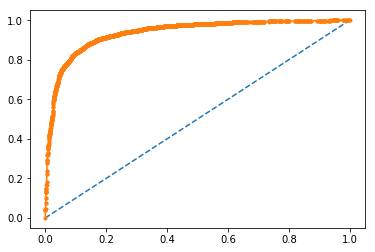

In [46]:
con_mat,clf = svc_results(100,final_counts,final_test_count,y_1,y_test)

Observation: Model predicted with accuracy 89% with AUC: 936

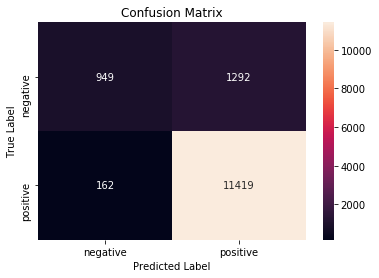

In [47]:
showHeatMap(con_mat)

Observation: MY model predicted 162 + 1292 points wrongly

# [6] Conclusions

| Method | No of samples | Algorithm | alpha or C value | accuray | AUC Score | regularizer |
| --- | --- | --- | --- | --- | --- | --- | --- | 
| BOW | 50000 | SGD | 0.0001 | 90 | 0.909 | l1 |
| BOW | 50000 | SGD | 0.0001 | 89 | 0.922 | l2 |
| TF-IDF | 50000 | SGD | 0.0001 | 90 | 0.938 | l1 |
| TF-IDF | 50000 | SGD | 0.0001 | 91 | 0.957 | l2 |
| AVG W2VEC | 50000 | SGD | 0.0001 | 87 | 0.888 | l1 |
| AVG W2VEC | 50000 | SGD | 0.0001 | 87 | 0.880 | l2 |
| TF_IDF AVG W2VEC | 50000 | SGD | 0.0001 | 83 | 0.840 | l1 |
| TF_IDF AVG W2VEC | 50000 | SGD | 0.0001 | 86 | 0.852 | l2 |
| BOW1 | 50000 | SGD | 100 | 88 | 0.906 |
| BOW | 50000 | SGD | 10000 | 88 | 0.907 |
| AVG W2VEC | 50000 | SGD | 100 | 88 | 0.906 |
| TF_IDF AVG W2VEC | 50000 | SGD | 0.0001 | 89 | 0.936 |